# Progress Report 1

In [1]:

from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data.sampler import SequentialSampler
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "./celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# We can use an image folder dataset the way we have it setup.


# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
#                                transforms.functional.to_grayscale,
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.01 * dataset_size))
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
test_sampler = SequentialSampler(test_indices)


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers,sampler=train_sampler)

dataloaderTest = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers,sampler=test_sampler)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Plot some training images
real_batch = next(iter(dataloader))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# # Training Loop

# # Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


# Loading
modelG = torch.load("netG.pt",map_location="cpu")
modelD = torch.load("netD.pt",map_location="cpu")
netD.load_state_dict(modelD)
netG.load_state_dict(modelG)
netD.eval()
netG.eval()


Random Seed:  999


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Utility Functions

In [2]:
display = lambda img: plt.imshow(np.transpose(vutils.make_grid(img,normalize=True),(1,2,0)))
reshapeZ = lambda z: z.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

In [64]:
def maskImage(img,size):
    """
    Parameters:
        img ==> pytorch tensor
        size ==> 2d tuple
    Mask given image with given size.
    Returns matrix, M, which has 1s where masking occured.
    """
    CHANNEL,COLUMN,ROW = img.size()
    middle = ((ROW//2)+13 , (COLUMN//2)+8)
    maskXOffset = (middle[0]-size[0],middle[0]+size[1])
    maskYOffset = (middle[1]-size[1],middle[1]+size[1])
    img[:,maskXOffset[0]:maskXOffset[1],maskYOffset[0]:maskYOffset[1]] = 0
    M = torch.ones([CHANNEL,COLUMN,ROW])
    M[:,maskXOffset[0]:maskXOffset[1],maskYOffset[0]:maskYOffset[1]] = 0
    return M  

### Example of Mask

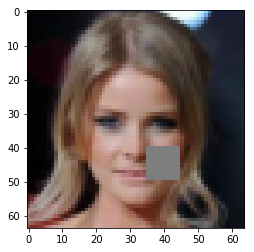

In [97]:
from PIL import Image
import torchvision.transforms.functional as TF
train_batch = next(iter(dataloaderTest))
#testImg = Image.open("test.jpg")
originalImage = train_batch[0][9]#TF.to_tensor(transforms.Resize((64,64))(testImg))
maskedImg = originalImage.clone()
M = maskImage(maskedImg,(5,5))
display(M*originalImage)

## Contextual Loss Function

This will help us generalize the context of the image well.  We will take difference of the generated image from damaged image. Low difference means that the pixels are not that different (ie. the pixels are very similar) and our context of the image is preserved.

$$ L_{contextual}(z) = ||M\odot Generated(z) - M\odot real||_1 $$

In [98]:
def contextualLoss(generated,real):
    return torch.sum(abs(M*generated - M*real).reshape(1,-1),dim=1)

## Perceptual Loss Function

$$ L_{perceptual}(z) = -log(D(G(z))) $$

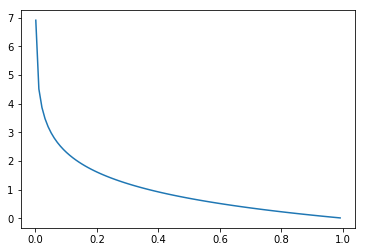

In [99]:
%matplotlib inline
x = np.arange(0.001,1,0.01)
plt.plot(x,-np.log(x));

In [100]:
def perceptualLoss(output):
    return -torch.log(netD(output)).flatten()

### Overall loss function for our inpainting is

$$ L(z) = L_{contextual}(z) + \lambda L_{perceptual}(z) $$

### and our goal is 
$$ \hat z = \arg \min_z L(z) $$

# Inpainting

In [101]:
import torch
import torch.nn as nn

class InpaintNet(nn.Module):  
    def __init__(self):
        super(InpaintNet, self).__init__()
        
        self.inputLayer = nn.Linear(100,100)
        self.outputLayer = nn.Linear(100,100,bias=False)  
    def forward(self,data):
        data = self.inputLayer(data)
        data = torch.sigmoid(self.outputLayer(data))
        return data
        

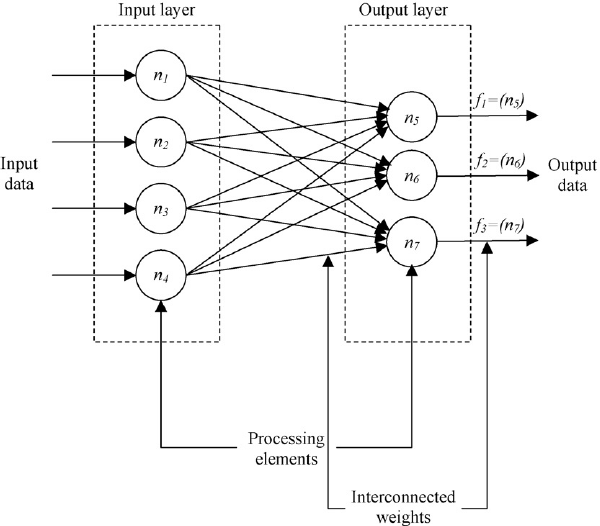

In [102]:
inpaintNet = InpaintNet()
optimizer = torch.optim.Adam(inpaintNet.parameters(), lr = 0.003)
z = torch.randn(nz,requires_grad=True)

In [103]:

z.grad = torch.zeros(nz)
outputImages =[]
error = []
for epoch in range(100):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    #z.grad.zero_()
    # forward + backward + optimize
    output = inpaintNet(z)
    generatedOutput = netG(reshapeZ(output))
    #generatedOutput = netG(reshapeZ(z))
    outputImages.append(generatedOutput.detach())
    predictedImage = (((1-M)*generatedOutput)) + maskedImg
    loss = contextualLoss(M*generatedOutput,maskedImg)+0.003*perceptualLoss(generatedOutput)
    #print(loss)
    error.append(loss.detach().tolist()[0])
#     print(z.grad[:4])
    loss.backward()
    optimizer.step()
#     print(z.grad[:4])
#     z.data -= z.grad
print('Finished Inpainting!')
#return predictedImage,outputImages,error

Finished Inpainting!


# Applying it to Testing Images

In [90]:
# predictedImgList = []
# outputImagesList = []
# errorList = []
# progress = 1
# N = 20

# testImg = train_batch[0][6]
# maskedImg = testImg
# M = maskImage(maskedImg,(5,5))
# predictedImg,outputImages,error = inpaint(maskedImg,M,netG,netD)
# predictedImgList.append(predictedImg[0].detach())
# outputImagesList.append(outputImages)
# errorList.append(error)
# print('Progress: ',progress,' / ',N//2)
# progress += 1    
    

Finished Inpainting!
Progress:  1  /  10


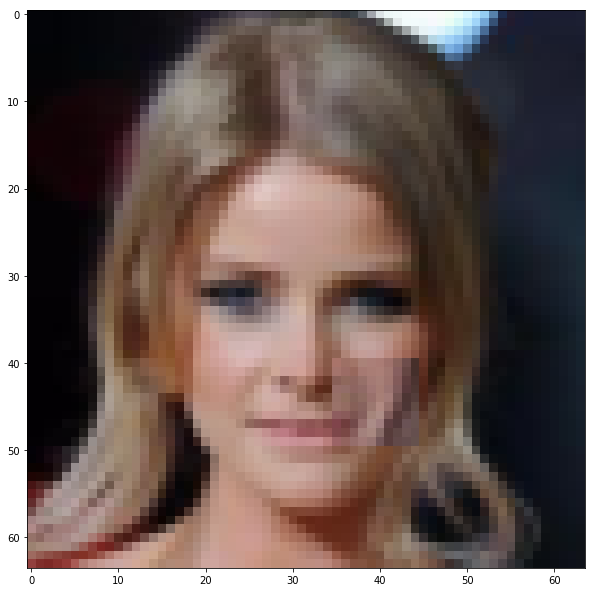

In [104]:
plt.figure(figsize = (10,50))
plt.imshow(np.transpose(vutils.make_grid(predictedImage.detach(), padding=2, normalize=True).cpu(),(1,2,0)))


## Visualizing Loss of our Inpainting

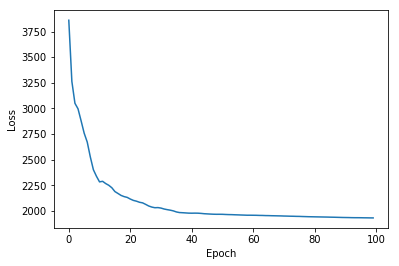

In [105]:
plt.plot(np.arange(0,100,1),error);
plt.xlabel("Epoch"); plt.ylabel("Loss");

## Final Result

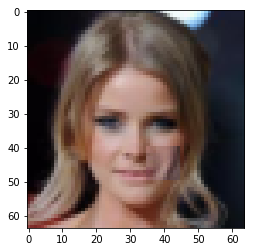

In [106]:
display(predictedImage.detach())

### Viewing Generated Images frame by frame

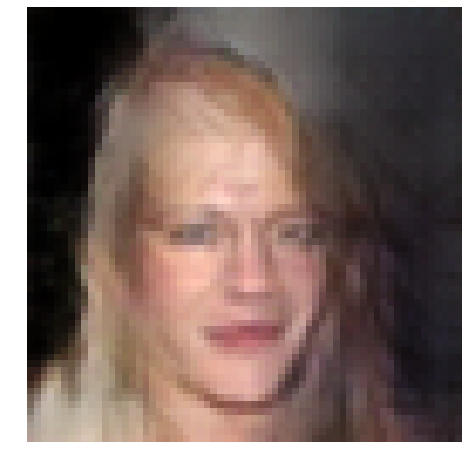

In [107]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(i[0],normalize=True),(1,2,0)), animated=True)] for i in outputImages]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

## Challenge With Updating Z

In [ ]:
z_copy = z.clone()
z_copy[:40]+=0.8
z_copy[40:]-=0.1
#print(z[:5])
display(netG(reshapeZ(z_copy)).detach())

The size of Z vector is 100. We have 100 variable to tweak but changing all the 100 variable by same gradient **does not** backpropagate to similar image.  We need to look at these 100 variable individually. Therefore, we propose a 100 diminesional input and output fully connected layer for finding optimial Z vector.

## Applying Poisson Blending 

In [ ]:
import cv2

In [ ]:
display((M)*maskedImg.detach())

In [ ]:
predictedImage.dtype

In [ ]:
generatedOutput[0].shape

In [ ]:
testing = np.zeros((3,1))

In [ ]:
testing.shape

In [ ]:
testing.transpose().shape

In [ ]:
source = plt.imread('source.png')
target = plt.imread('target.png')
mask = plt.imread('mask.png')

In [ ]:
# import torchvision
# torchvision.utils.save_image((1-M).detach(),'mask.png')
# torchvision.utils.save_image((1-M)*generatedOutput.detach(),'source.png')
# torchvision.utils.save_image((M*maskedImg).detach(),'target.png')


In [ ]:
output = cv2.seamlessClone(src=source, dst=target, mask=mask ,p=(20,20),blend=target, flags=cv2.NORMAL_CLONE)

In [ ]:
cv2.seamlessClone?